In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

---

# Choosing the Best "zulo40"

In [43]:
models_folder = "ModelBuild/"
results_file = "/results.json"

models = [#"Metadata (efnet (zulo40))",
          #"Metadata (efnet) 02",
          #"Metadata (efnet) 03",
          #"Metadata (efnet) 04",
          #"Metadata (efnet) 05",
          "Metadata (efnet) 06",]

models_mae = {} 
for model in models:
    with open(models_folder + model + results_file) as f:
        data = json.load(f)
    avg_mae = 0
    for fold in data:
        avg_mae += data[fold]["Best Mae"]
    avg_mae /= len(data)
    models_mae[model] = avg_mae

best_model = min(models_mae, key=models_mae.get)
print("Best Model based on CV MAE:")
print(f"{best_model} with MAE {models_mae[best_model]}")

Best Model based on CV MAE:
Metadata (efnet) 06 with MAE 1.153822660446167


Fold 0
Model stopped at epoch 66 with mae 0.9903514385223389
Fold 1
Model stopped at epoch 53 with mae 1.1910563707351685
Fold 2
Model stopped at epoch 38 with mae 1.2800601720809937


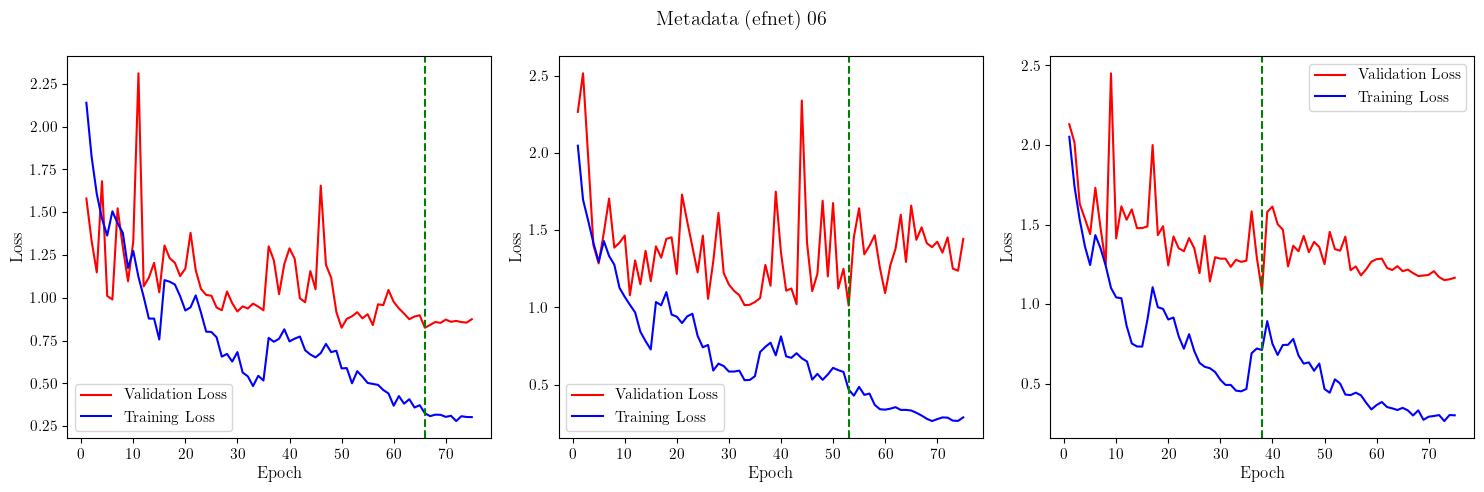

In [44]:
with open(f"ModelBuild/{best_model}/results.json") as json_file:
    metadata_zulo40 = json.load(json_file)

plt.figure(figsize=(15, 5))
plt.suptitle(f"{best_model}")
for fold in metadata_zulo40:
    print(f"{fold}")
    print(f"Model stopped at epoch {metadata_zulo40[fold]['Results']['model_from_epoch']}")

    plt.subplot(1, 3, int(fold.split(" ")[-1])+1)
    val_loss = metadata_zulo40[fold]['Results']['val_loss']
    train_loss = metadata_zulo40[fold]['Results']['train_loss']

    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.axvline(x=int(metadata_zulo40[fold]['Results']['model_from_epoch'][:2]), color='g', linestyle='--')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

**fazer mean cv val e train: 3 até 37, 2 até 53, 1 até 65 epochs** NÃO: TENHO DE FAZER SMP MEDIA DE 3 MAS FIXO O ULTIMO RESULTADO DE CADA UM, TP LINHA CONSTANTE

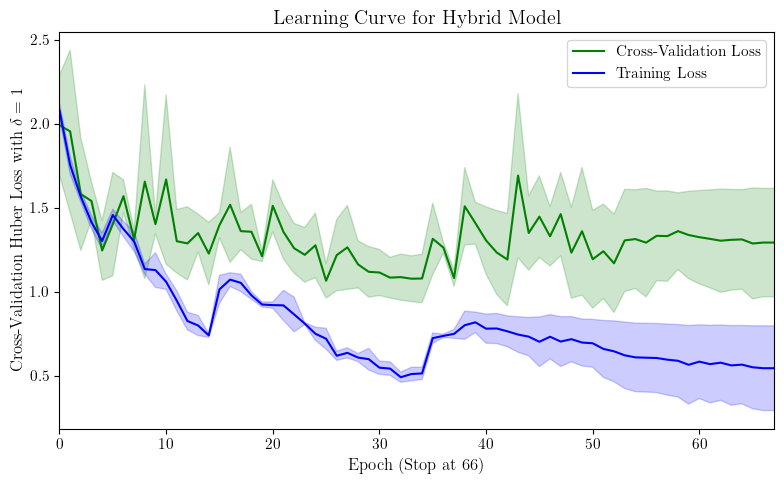

In [45]:
validation = []
loss = []
stops = []

for fold in metadata_zulo40:
    val_mean = []
    train_mean = []

    early_stop = int(metadata_zulo40[fold]['Results']['model_from_epoch'][:2])
    stops.append(early_stop)
    for i in range(early_stop):
        val_mean.append(metadata_zulo40[fold]['Results']['val_loss'][i])
        train_mean.append(metadata_zulo40[fold]['Results']['train_loss'][i])
    for i in range(early_stop, len(metadata_zulo40[fold]['Results']['val_loss'])):
        val_mean.append(metadata_zulo40[fold]['Results']['val_loss'][early_stop])
        train_mean.append(metadata_zulo40[fold]['Results']['train_loss'][early_stop])

    validation.append(val_mean)
    loss.append(train_mean)

validation_mean = np.mean(validation, axis=0)
validation_std = np.std(validation, axis=0)
loss_mean = np.mean(loss, axis=0)
loss_std = np.std(loss, axis=0)
plt.figure(figsize=(8, 5))
plt.title(f"Learning Curve for Hybrid Model")
plt.plot(validation_mean, 'g', label='Cross-Validation Loss')
plt.fill_between(range(len(validation_mean)), validation_mean-validation_std, validation_mean+validation_std, color='g', alpha=0.2)
plt.plot(loss_mean, 'b', label='Training Loss')
# smooth fill between
plt.fill_between(range(len(loss_mean)), loss_mean-loss_std, loss_mean+loss_std, color='b', alpha=0.2)
plt.legend()
plt.xlabel(f'Epoch (Stop at {int(np.max(stops))})')
plt.ylabel('Cross-Validation Huber Loss with $\delta = 1$')
plt.tight_layout()
plt.xlim(0, max(stops)+1)
#plt.savefig("assets/model01_lc.png", transparent=True)
plt.show()

train mae - full train dataset

In [46]:
train_pred = pd.read_csv(f"ModelBuild/{best_model}/submission_train.csv")
train_true = pd.read_csv("Train.csv")

# remove duplicates in train_pred
train_pred.drop_duplicates(subset=['ID'], keep='last', inplace=True)

# merge same id, with sum in boil_nbr and pan_nbr
train_true = train_true.groupby(['ID']).agg({'boil_nbr': 'sum', 'pan_nbr': 'sum'}).reset_index()

# one column only for true set
train_true_df = {
    "ID": [],
    "Target": [],
}
for index, row in train_true.iterrows():
    train_true_df["ID"].append(f'{row["ID"]}_boil')
    train_true_df["Target"].append(row["boil_nbr"])
    train_true_df["ID"].append(f'{row["ID"]}_pan')
    train_true_df["Target"].append(row["pan_nbr"])
train_true = pd.DataFrame(train_true_df)

# compute mae
train_pred = train_pred.merge(train_true, on="ID", how="inner")
train_pred["ae"] = abs(train_pred["Target_x"] - train_pred["Target_y"])
train_pred["mae"] = train_pred["ae"].mean()

print(f"Train MAE: {train_pred['mae'].values[0]}")
print(f"Validation mean MAE during CV: {1.153822660446167}")
print(f"Test MAE: {0.843495934}")

Train MAE: 0.5126811594202898
Validation mean MAE during CV: 1.153822660446167
Test MAE: 0.843495934


# Choosing the Best YOLO-seg

In [47]:
yolos = {
    "YOLOv8L 03 (cv)_0": [
        "Jset_0_fold_0_val.csv",
        "Jset_0_fold_1_val.csv",
        "Jset_0_fold_2_val.csv"
    ],
    "YOLOv8L 03 (cv)_1": [
        "Jset_1_fold_0_val.csv",
        "Jset_1_fold_1_val.csv",
        "Jset_1_fold_2_val.csv"
    ],
    "YOLOv8L 03 (cv)_2": [
        "Jset_2_fold_0_val.csv",
        "Jset_2_fold_1_val.csv",
        "Jset_2_fold_2_val.csv"
    ],
    "YOLOv11L 01 (cv)": [
        "fold_0_val.csv",
        "fold_1_val.csv",
        "fold_2_val.csv",
    ],
    "YOLOv11L 02 (cv)": [
        "model_0_val.csv",
        "model_1_val.csv",
        "model_2_val.csv",
    ],
    "YOLOv11M 07 (cv)": [
        "fold_0_val.csv",
        "fold_1_val.csv",
        "fold_2_val.csv",
    ]
}

In [48]:
train_true = pd.read_csv("Train.csv")
train_true = train_true.groupby(['ID']).agg({'boil_nbr': 'sum', 'pan_nbr': 'sum'}).reset_index()
train_true.head(1)

,ID,boil_nbr,pan_nbr
0,ID00rw8,0,2


In [49]:
maes = {}
for model in yolos:
    maes[model] = {}
    for fold in yolos[model]:
        pred_val = pd.read_csv(f"ModelBuild/{model.split('_')[0]}/{fold}")
        pred_val["ID"] = pred_val["ID"].map(lambda x: x.split(".")[0])
        merge = pred_val.merge(train_true, on="ID", how="inner")

        mae_boil = (merge["boil_nbr"] - merge["boil"]).abs().mean()
        mae_pan = (merge["pan_nbr"] - merge["pan"]).abs().mean()
        mae = (mae_boil + mae_pan) / 2

        maes[model][fold] = mae

In [52]:
df

,Model,MAE
0,YOLOv8L 03 (cv)_0,0.375740
1,YOLOv8L 03 (cv)_0,0.761834
2,YOLOv8L 03 (cv)_0,0.480712
3,YOLOv8L 03 (cv)_1,0.409763
4,YOLOv8L 03 (cv)_1,0.788462
5,YOLOv8L 03 (cv)_1,0.350148
6,YOLOv8L 03 (cv)_2,0.378698
7,YOLOv8L 03 (cv)_2,0.557692
8,YOLOv8L 03 (cv)_2,0.326409
9,YOLOv11L 01 (cv),0.388626


<Figure size 1200x600 with 0 Axes>

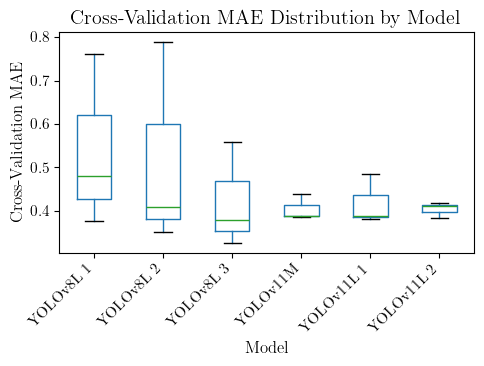

YOLOv8L 03 (cv)_0: 0.5394
YOLOv8L 03 (cv)_1: 0.5161
YOLOv8L 03 (cv)_2: 0.4209
YOLOv11L 01 (cv): 0.4186
YOLOv11L 02 (cv): 0.4036
YOLOv11M 07 (cv): 0.4044


In [ ]:
records = []
for model, results in maes.items():
    for fold_name, mae in results.items():
        records.append({'Model': model, 'MAE': mae})
df = pd.DataFrame(records)
models_x = {"YOLOv11L 01 (cv)": "YOLOv11L 1",
            "YOLOv11L 02 (cv)": "YOLOv11L 2",
            "YOLOv11M 07 (cv)": "YOLOv11M",
            "YOLOv8L 03 (cv)_0": "YOLOv8L 1",
            "YOLOv8L 03 (cv)_1": "YOLOv8L 2",
            "YOLOv8L 03 (cv)_2": "YOLOv8L 3"}
df["Model_x"] = df["Model"].map(models_x)

custom_order = ['YOLOv8L 1', 'YOLOv8L 2', 'YOLOv8L 3', 'YOLOv11M', 'YOLOv11L 1', 'YOLOv11L 2']
df['Model_x'] = pd.Categorical(df['Model_x'], categories=custom_order, ordered=True)

df_sorted = df.sort_values('Model_x')

# Plot the boxplot
plt.figure(figsize=(12, 6))
df_sorted.boxplot(by='Model_x', column='MAE', grid=False)
plt.xticks(rotation=45, ha='right')
plt.title('Cross-Validation MAE Distribution by Model')
plt.suptitle('')  # Remove the default title
plt.ylabel('Cross-Validation MAE')
plt.xlabel('Model')
plt.tight_layout()
#plt.savefig("assets/model02_mae_boxplot.png", transparent=True)
plt.show()

for model, results in maes.items():
    print(f"{model}: {np.mean(list(results.values())):.4f}")

In [ ]:
print(f"Best YOLO-seg Model based on CV MAE: {min(maes, key=lambda x: np.mean(list(maes[x].values())))}")

Best YOLO-seg Model based on CV MAE: YOLOv11L 02 (cv)


In [ ]:
print(f"Test MAE: {1.341463414}")
print(f"Train MAE: {1.5644625603864735}")

Test MAE: 1.341463414
Train MAE: 1.5644625603864735


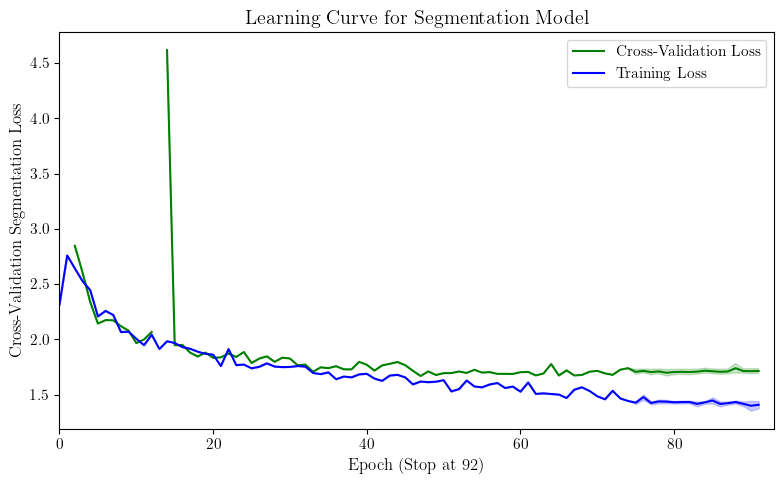

In [ ]:
df01 = pd.read_csv("ModelBuild/YOLOv11L 02 (cv)/model_1/results.csv")
df02 = pd.read_csv("ModelBuild/YOLOv11L 02 (cv)/model_2/results.csv")
df03 = pd.read_csv("ModelBuild/YOLOv11L 02 (cv)/model_0/results.csv")

stop = []
for df in [df01, df02, df03]:
    min_val = df['val/seg_loss'].min()
    min_index = df['val/seg_loss'].idxmin()
    stop.append(min_index)

metrics = {
    "train1": [],
    "train2": [],
    "train3": [],
    "val1": [],
    "val2": [],
    "val3": [],
}
for model in range(3):
    for i in range(max(stop)):
        if i <= stop[model]:
            metrics["train" + str(model+1)].append(df01.iloc[i]['train/seg_loss'])
            metrics["val" + str(model+1)].append(df01.iloc[i]['val/seg_loss'])
        else:
            metrics["train" + str(model+1)].append(df01.iloc[stop[model]]['train/seg_loss'])
            metrics["val" + str(model+1)].append(df01.iloc[stop[model]]['val/seg_loss'])


validation = [metrics["val1"], metrics["val2"], metrics["val3"]]
loss = [metrics["train1"], metrics["train2"], metrics["train3"]]
validation_mean = np.mean(validation, axis=0)
validation_std = np.std(validation, axis=0)
loss_mean = np.mean(loss, axis=0)
loss_std = np.std(loss, axis=0)
plt.figure(figsize=(8, 5))
plt.title(f"Learning Curve for Segmentation Model")
plt.plot(validation_mean, 'g', label='Cross-Validation Loss')
plt.fill_between(range(len(validation_mean)), validation_mean-validation_std, validation_mean+validation_std, color='g', alpha=0.2)
plt.plot(loss_mean, 'b', label='Training Loss')
# smooth fill between
plt.fill_between(range(len(loss_mean)), loss_mean-loss_std, loss_mean+loss_std, color='b', alpha=0.2)
plt.legend()
plt.xlabel(f'Epoch (Stop at {int(np.max(stop))})')
plt.ylabel('Cross-Validation Segmentation Loss')
plt.tight_layout()
plt.xlim(0, max(stop)+1)
#plt.savefig("assets/model02_lc.png", transparent=True)
plt.show()

# Choosing the Best Obj Id